In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import cv2 # cv2 for reading and processing the images
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import *
import seaborn as sns

from sklearn.model_selection import train_test_split
# Keras libraries
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
# other libraries
import gc
import random
import os

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
print(os.listdir("../input/cell_images/cell_images"))

['Uninfected', 'Parasitized']


In [3]:
img_height = 112
img_width = 112
img_channels = 3
np_random_seed = 41

In [4]:
def read_and_process_images(data_dir, image_dims = (56,56), num_of_imgs = None, convert_to_categorical = True):
    """
    Function to read the images from the given directory and returns Numpy array of X, y and array of labels (names of the directory)
    
    The function reads from the given directory, it considers each immidiate sub-directory as a lable
    
    Parameters: 
    data_dir (String): Path to the directory
    image_dims (tuple): Dimensions of the image (length, bredth). 
    num_of_imgs (int): Total number of images to be loaded, if None all the images are loaded. Equal amount of images from each sub-directory are loaded. eg: If input is 30 and there are three subdirectories then 10 images from each directory are loaded
    convert_to_categorical (boolean): If true then y is converted to one hot vector else a single np array of series of number for each lable starting with 0
  
    Returns: 
    int: Description of return value 
  
    """
    # initialize empty python arrays for X and y
    X = []
    y = []
    
    num_of_img_per_class = 0
    labels = [ name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name)) ]
    if num_of_imgs is not None:
        num_of_img_per_class = int(round(num_of_imgs/len(labels)))
        
    print('num_of_img_per_class : '+str(num_of_img_per_class if num_of_img_per_class > 0 else 'All' ))
    
    lable_count = 0
    #importing the Parasitized images
    for label in labels:
        size = 0
        print('Importing lable : '+str(label))
        for imgpath in os.listdir(data_dir+'/'+label):
            try:
                X.append(cv2.resize(cv2.imread(data_dir+'/'+label+'/'+imgpath, cv2.IMREAD_COLOR), image_dims, interpolation=cv2.INTER_CUBIC))
                y.append(lable_count)
            except BaseException as err:
                print('Error readding file :"'+label+'/'+imgpath+'", '+str(err))
            
            size += 1
            
            if num_of_img_per_class == size :
                break
        print('Imported lable : '+str(label))
        lable_count =+ 1
    
    # converting the python array into Numpy array
    X_np = np.array(X)
    y_temp = np.array(y)
    
    # converting the y variables to categorical
    if(convert_to_categorical) :
        y_np = to_categorical(y_temp,len(labels))
        del y_temp
        gc.collect()
    else:
        y_np = y_temp
    print ('converted to np arrays')
    
    # deleting the python arrays as they are no longer required and it would reduce the memory
    del X
    del y
    gc.collect()
    print ('deleted temp arrays')

    # Normalizing and converting the data into float
    X_np.astype('float32')/255.0
    print ('data normalized')

    return X_np, y_np, labels

In [5]:
np.random.seed(np_random_seed)
X, y, lables = read_and_process_images('../input/cell_images/cell_images', image_dims=(img_height,img_width))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle = True,stratify = y)
print('X_train Shape : '+str(X_train.shape))
print('X_test Shape : '+str(X_test.shape))
print('y_train Shape : '+str(y_train.shape))
print('y_test Shape : '+str(y_test.shape))

num_of_img_per_class : All
Importing lable : Uninfected
Error readding file :"Uninfected/Thumbs.db", OpenCV(4.1.0) /io/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Imported lable : Uninfected
Importing lable : Parasitized
Error readding file :"Parasitized/Thumbs.db", OpenCV(4.1.0) /io/opencv/modules/imgproc/src/resize.cpp:3718: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Imported lable : Parasitized
converted to np arrays
deleted temp arrays
data normalized
X_train Shape : (24802, 112, 112, 3)
X_test Shape : (2756, 112, 112, 3)
y_train Shape : (24802, 2)
y_test Shape : (2756, 2)


In [6]:
def show_images(X, y, start_idx = 0,num_imgs = 10, img_per_row = 5):
    """
    Displays the images from the given data X
    
    Parameters: 
    X (numpy.array) : Numpy array of images
    start_idx(int) : Index from where we start viewing the, make sure that the number doesnot exceed the length of the X_train
    num_imgs (int) : Total number of images that have to be displayed
    img_per_row (int) : Number of images that have to be displayed per row
    """
    num_rows = int(num_imgs/img_per_row) + 1
    plt.figure(figsize = (18,4 * num_rows))
    for i in range(1,num_imgs+1):
        plt.subplot(num_rows,img_per_row,i)
        plt.title(str(lables[np.argmax(y[start_idx])]))
        plt.imshow(X_train[start_idx])
        start_idx += 1

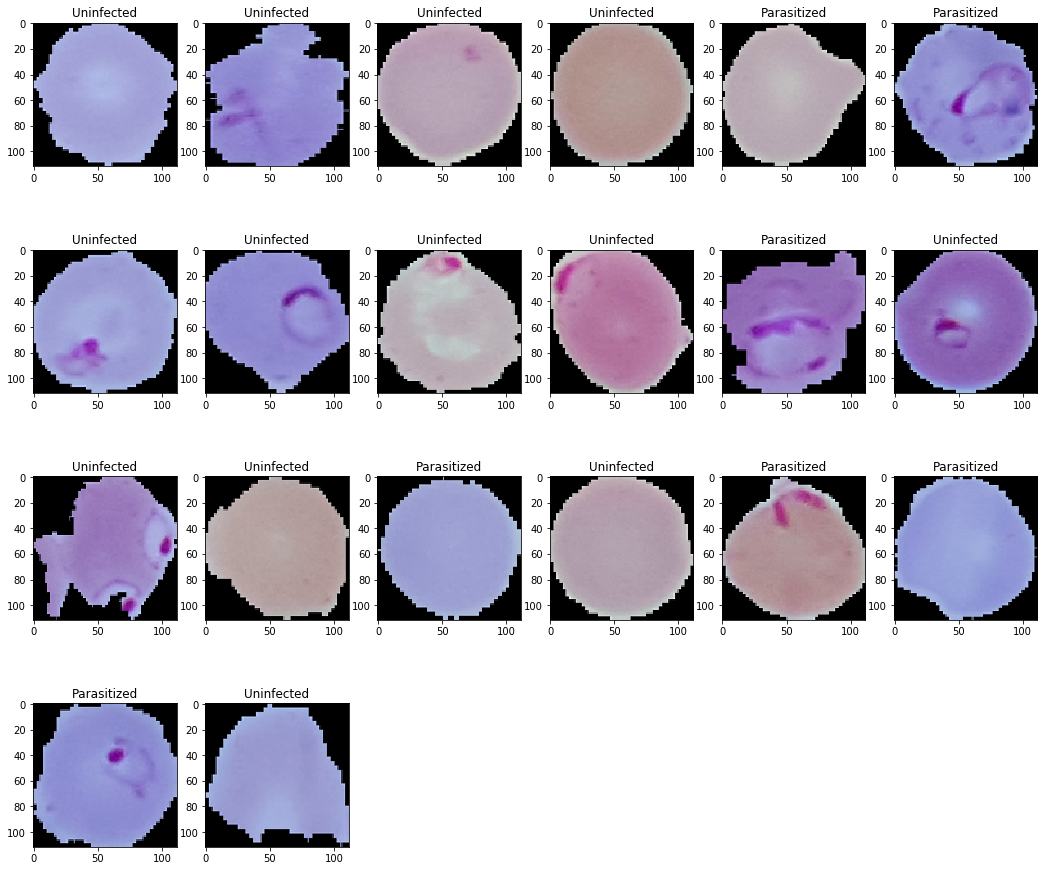

In [7]:
show_images(X_test, y_test,100, 20,6)

In [8]:
base_model = ResNet50(include_top=False, 
                      weights='imagenet', 
                      input_shape=(img_height, img_width, img_channels))
base_model.trainable = True #Tells that all the weights are to be trained

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [9]:
model= models.Sequential()           #Creating the sequntial model
model.add(base_model)                #Adding the imagenet model
model.add(Flatten())                                #
model.add(Dense(512,activation="relu"))             #
model.add(Dropout(0.2))                             #
model.add(Dense(len(lables),activation="softmax"))  #
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 40,366,466
Trainable params: 40,313,346
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(4e-5), metrics=['accuracy'])

In [11]:
his = model.fit(X_train,y_train,batch_size=32, epochs= 5, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 19841 samples, validate on 4961 samples
Epoch 1/5
19841/19841 [==============================] - 4193s 211ms/step - loss: 0.1847 - acc: 0.9377 - val_loss: 0.1235 - val_acc: 0.9629
Epoch 2/5
19841/19841 [==============================] - 4134s 208ms/step - loss: 0.0605 - acc: 0.9794 - val_loss: 0.1257 - val_acc: 0.9567
Epoch 3/5
19841/19841 [==============================] - 4140s 209ms/step - loss: 0.0310 - acc: 0.9886 - val_loss: 0.1350 - val_acc: 0.9641
Epoch 4/5
19841/19841 [==============================] - 4159s 210ms/step - loss: 0.0227 - acc: 0.9919 - val_loss: 0.1832 - val_acc: 0.9532
Epoch 5/5
19841/19841 [==============================] - 4201s 212ms/step - loss: 0.0282 - acc: 0.9910 - val_loss: 0.1692 - val_acc: 0.9615


In [12]:
accuracy = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

2756/2756 [==============================] - 120s 44ms/step

 Test_Accuracy:- 0.9608127721335269


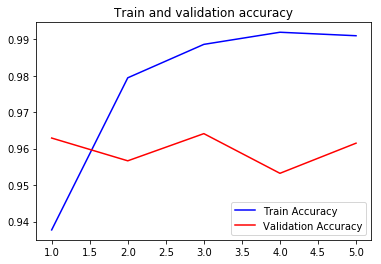

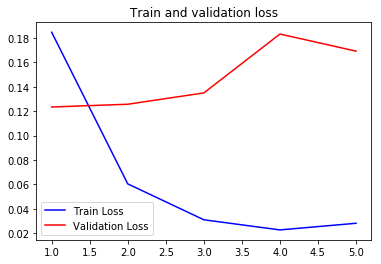

In [13]:
train_accs = his.history['acc']
train_losses = his.history['loss']
val_accs = his.history['val_acc']
val_losses = his.history['val_loss']

epochs = range(1, len(train_accs)+1)

plt.plot(epochs,train_accs, 'b', label='Train Accuracy')
plt.plot(epochs,val_accs, 'r', label='Validation Accuracy')
plt.title('Train and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,train_losses, 'b', label='Train Loss')
plt.plot(epochs,val_losses, 'r', label='Validation Loss')
plt.title('Train and validation loss')
plt.legend()

plt.show()